#### Проект: Статистический анализ данных

Задача проекта: проанализировать данные о пользователях сервиса аренды самокатов, а также об их поездках, проверить следующие гипотезы:
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 0. Описание данных

*Пользователи* - users_go.csv

| Столбец | Описание |
| :--- | :--- |
| user_id | уникальный идентификатор пользователя |
| name | имя пользователя |
| age | возраст |
| city | город |
| subscription_type | тип подписки (free, ultra) |

*Поездки* - rides_go.csv

| Столбец | Описание |
| :--- | :--- |
| user_id | уникальный идентификатор пользователя |
| distance | расстояние, которое пользователь проехал в текущей сессии (в метрах) |
| duration | продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку» |
| date | дата совершения поездки |

*Подписки* - subscriptions_go.csv

| Столбец | Описание |
| :--- | :--- |
| subscription_type | тип подписки |
| minute_price | стоимость одной минуты поездки по данной подписке |
| start_ride_price | стоимость начала поездки |
| subscription_fee | стоимость ежемесячного платежа |

#### Шаг 1. Загрузка данных

In [3]:
#пользователи

users_df = pd.read_csv('/datasets/users_go.csv')
display(users_df.head())
users_df.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [3]:
users_df['city'].value_counts()

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

In [4]:
#поездки

rides_df = pd.read_csv('/datasets/rides_go.csv')
display(rides_df.head())
rides_df.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
#подписки

subscriptions_df = pd.read_csv('/datasets/subscriptions_go.csv')
display(subscriptions_df.head())
subscriptions_df.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В нашем распоряжении 3 датафрейма:
1. users_df (информация о пользователях) - 5 столбцов, 1565 строк, пропусков нет, есть данные по 8 городам, в столбце 'subscription_type' только 2 значения -> можно изменить тип данных на bool (0 - free, 1- ultra)
2. riders_df (информация о поездках) - 4 столбца, 18068 строк, пропусков нет, в столбце 'date' следует изменить тип данных на datetime
3. subscriptions_df (информация о подписках) - 4 столбца, 2 строки, пропусков нет

#### Шаг 2. Предобработка данных

In [6]:
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%d') #приводим формат данных столбца 'date' к типу даты
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [7]:
rides_df['month'] = pd.DatetimeIndex(rides_df['date']).month #создаем новый столбец с номером месяца
rides_df.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [8]:
users_df.duplicated().sum() #поиск явных дубликатов в users_df (31)
users_df = users_df.drop_duplicates() #удаляем дубликаты

В датафрейме с поездками был изменен тип данных столбца 'date' на тип даты, а также создан новый столбец с номером месяца поездки. В датафрейме с пользователями были обнаружены и удалены явные дубликаты.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

Пятигорск         14.276402
Екатеринбург      13.298566
Ростов-на-Дону    12.907432
Краснодар         12.581486
Сочи              12.320730
Омск              11.929596
Тюмень            11.734029
Москва            10.951760
Name: city, dtype: float64

<AxesSubplot:title={'center':'доля встречаемости городов, %'}, xlabel='город', ylabel='доля'>

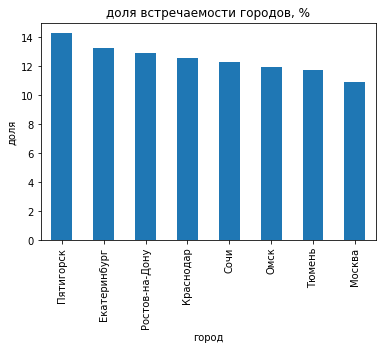

In [9]:
display(users_df['city'].value_counts() / users_df.shape[0] * 100)
(users_df['city'].value_counts() / users_df.shape[0] * 100).plot.bar(title='доля встречаемости городов, %', xlabel='город', ylabel='доля') #распределение пользователей по городам

##### Cоотношение пользователей с подпиской и без подписки

free     54.432855
ultra    45.567145
Name: subscription_type, dtype: float64

<AxesSubplot:title={'center':'соотношение пользователей с подпиской и без'}, ylabel='тип подписки'>

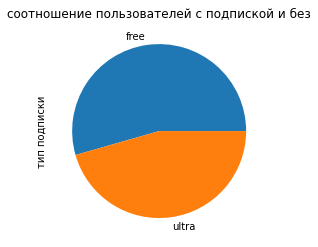

In [10]:
display(users_df['subscription_type'].value_counts() / users_df.shape[0] * 100) #соотношение пользователей с подпиской и без
(users_df['subscription_type'].value_counts() / users_df.shape[0] * 100).plot(kind='pie', title='соотношение пользователей с подпиской и без', ylabel='тип подписки')

##### Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Text(0, 0.5, 'кол-во пользователей')

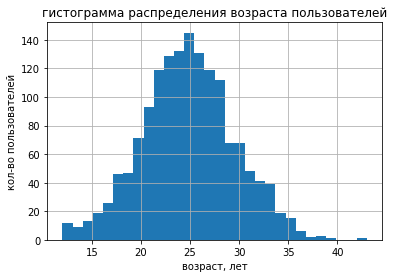

In [11]:
display(users_df['age'].describe()) #информация о возрасте пользователей
users_df['age'].hist(bins=30)
plt.title('гистограмма распределения возраста пользователей')
plt.xlabel('возраст, лет')
plt.ylabel('кол-во пользователей')

##### Расстояние поездок

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Text(0, 0.5, 'кол-во поездок')

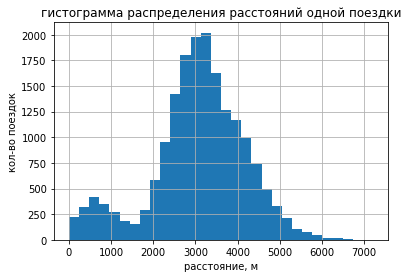

In [12]:
display(rides_df['distance'].describe()) #информация о расстоянии поездок
rides_df['distance'].hist(bins=30)
plt.title('гистограмма распределения расстояний одной поездки')
plt.xlabel('расстояние, м')
plt.ylabel('кол-во поездок')

Text(0, 0.5, 'расстояние, м')

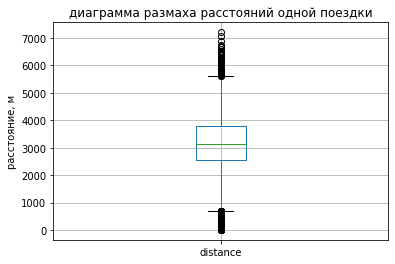

In [13]:
rides_df.boxplot('distance')
plt.title('диаграмма размаха расстояний одной поездки')
plt.ylabel('расстояние, м')

##### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Text(0, 0.5, 'кол-во поездок')

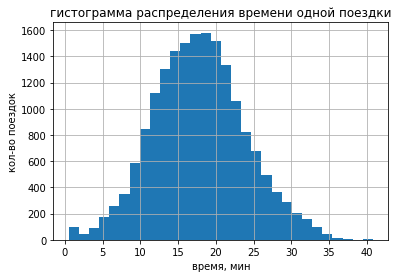

In [14]:
display(rides_df['duration'].describe()) #информация о времени поездок
rides_df['duration'].hist(bins=30)
plt.title('гистограмма распределения времени одной поездки')
plt.xlabel('время, мин')
plt.ylabel('кол-во поездок')

Text(0, 0.5, 'время, мин')

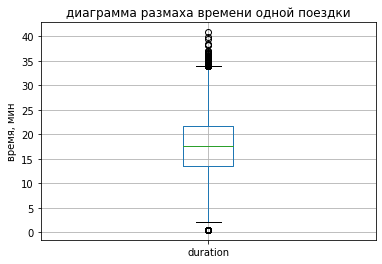

In [15]:
rides_df.boxplot('duration')
plt.title('диаграмма размаха времени одной поездки')
plt.ylabel('время, мин')

Доли пользователей по городам распределены равномерно, всех больше в Пятигорске (14%), всех меньше в Москве (11%). Пользователей с подпиской чуть меньше (45,6), чем пользователей без нее (54,4). График распределения возраста имеет вид нормального распределения со средним значением в 24,9 лет. Графики распределения расстояния и времени имеют вид нормального распределения (на гистограмме дистанции есть еще малый пик в районе ~500 м) со средними 3070,7 м и 17,8 минут соотвественно. Также на диаграммах размаха расстояния и времени видим аномальные значения как сверху, так и снизу

#### Шаг 4. Объединение данных

In [16]:
subtotal_df = users_df.merge(rides_df, on='user_id')
total_df = subtotal_df.merge(subscriptions_df, on='subscription_type') #объединенный датафрейм
total_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [17]:
free_users = total_df.query('subscription_type == "free"') #дф о пользователях без подписки
ultra_users = total_df.query('subscription_type == "ultra"') #дф о пользователях с подпиской

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

Text(0, 0.5, 'кол-во поездок')

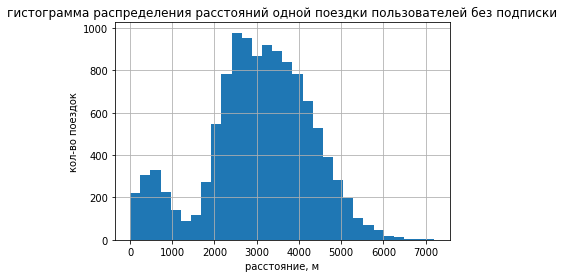

In [18]:
display(free_users['distance'].describe()) #расстояние поездок пользователей без подписки
free_users['distance'].hist(bins=30)
plt.title('гистограмма распределения расстояний одной поездки пользователей без подписки')
plt.xlabel('расстояние, м')
plt.ylabel('кол-во поездок')

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Text(0, 0.5, 'кол-во поездок')

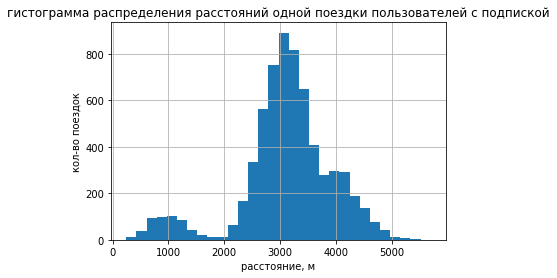

In [19]:
display(ultra_users['distance'].describe()) #расстояние поездок пользователей с подпиской
ultra_users['distance'].hist(bins=30)
plt.title('гистограмма распределения расстояний одной поездки пользователей с подпиской')
plt.xlabel('расстояние, м')
plt.ylabel('кол-во поездок')

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

Text(0, 0.5, 'кол-во поездок')

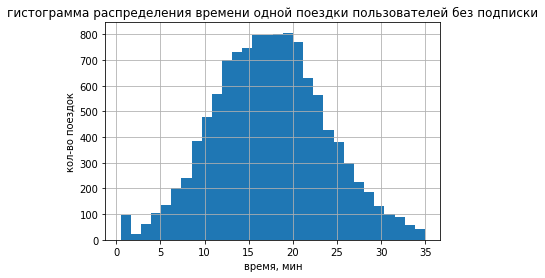

In [20]:
display(free_users['duration'].describe()) #время поездок пользователей без подписки
free_users['duration'].hist(bins=30)
plt.title('гистограмма распределения времени одной поездки пользователей без подписки')
plt.xlabel('время, мин')
plt.ylabel('кол-во поездок')

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Text(0, 0.5, 'кол-во поездок')

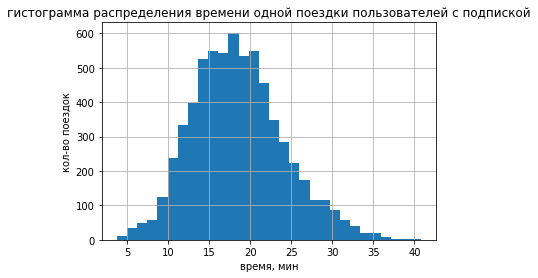

In [21]:
display(ultra_users['duration'].describe()) #время поездок пользователей с подпиской
ultra_users['duration'].hist(bins=30)
plt.title('гистограмма распределения времени одной поездки пользователей с подпиской')
plt.xlabel('время, мин')
plt.ylabel('кол-во поездок')

Кол-во поездок пользователей без подписки почти в два раза больше, чем у пользователей с подпиской. Среднее преодолеваемое расстояние и у тех и у других чуть больше 3 км. Пользователи с подпиской, в среднем, используют самокат на 1 минуту дольше, чем пользователи без подписки

#### Шаг 5. Подсчёт выручки

In [22]:
total_df['duration'] = np.ceil(total_df['duration']).astype('int') #округляем суммарное время до целого числа вверх и приводим тип данных в столбце к int
total_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27,2021-08-28,8,6,0,199


In [23]:
month_pivot = total_df.pivot_table(index=['user_id', 'month', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'], values=['distance', 'duration'], aggfunc={'distance': ['count', 'sum'], 'duration': 'sum'}) #создаем сводную таблицу с данными поездок для каждого пользователя по месяцам
month_pivot.columns = ['count', 'sum_distance', 'sum_duration'] #переименовываем названия столбцов
month_pivot.head()

count  \
user_id month subscription_type minute_price start_ride_price subscription_fee          
1       1     ultra             6            0                199                   2   
        4     ultra             6            0                199                   1   
        8     ultra             6            0                199                   2   
        10    ultra             6            0                199                   2   
        11    ultra             6            0                199                   3   

                                                                                sum_distance  \
user_id month subscription_type minute_price start_ride_price subscription_fee                 
1       1     ultra             6            0                199                7027.511294   
        4     ultra             6            0                199                 754.159807   
        8     ultra             6            0                199                6723.470560   
        10    ultra             6            0                199                5809.911100   
        11    ultra             6            0                199                7003.499363   

                                                                                sum_duration  
user_id month subscription_type minute_price start_ride_price subscription_fee                
1       1     ultra             6            0                199                         42  
        4     ultra             6            0                199                          7  
        8     ultra             6            0                199                         46  
        10    ultra             6            0                199                         32  
        11    ultra             6            0                199                         56

In [24]:
month_pivot.reset_index(inplace=True) #ничего лучше не придумал, без этого следующая строка не работала
month_pivot['monthly_revenue'] = month_pivot['start_ride_price'] * month_pivot['count'] + month_pivot['minute_price'] * month_pivot['sum_duration'] + month_pivot['subscription_fee'] #рассчитываем помесячную выручку от пользователя по месяцам
month_pivot.head()

,user_id,month,subscription_type,minute_price,start_ride_price,subscription_fee,count,sum_distance,sum_duration,monthly_revenue
0,1,1,ultra,6,0,199,2,7027.511294,42,451
1,1,4,ultra,6,0,199,1,754.159807,7,241
2,1,8,ultra,6,0,199,2,6723.470560,46,475
3,1,10,ultra,6,0,199,2,5809.911100,32,391
4,1,11,ultra,6,0,199,3,7003.499363,56,535


#### Шаг 6. Проверка гипотез

##### Проверка гипотезы: тратят ли пользователи с подпиской больше времени на поездки?

Здесь первая генеральная совокупность (с подпиской) меньше второй (без подписки) почти в 2 раза, стоит ли здесь здесь оценивать вторую по выборке или это касается очень больших объемов данных? Если да (стОит), то к такому меня жизнь не готовила.

H<sub>0</sub>: между средними значениями двух совокупностей нет разницы, они равны  
H<sub>1</sub>: среднее значение первой генеральной совокупности (с подпиской) больше среднего значения второй генеральной совокупности (без подписки)

In [25]:
alpha = .05 #уровень статистической значимости

results = st.ttest_ind(ultra_users['duration'], free_users['duration'], alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')



p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки  
P.S. похожий вывод сделан в шаге 4

##### Проверка гипотезы: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

H<sub>0</sub>: среднее расстояние, которое проезжаю пользователи с подпиской за одну поездку равно 3130 м  
H<sub>1</sub>: среднее расстояние, которое проезжаю пользователи с подпиской за одну поездку больше 3130 м

In [26]:
alpha = .05 #уровень статистической значимости

avg_distance = 3130

results = st.ttest_1samp(ultra_users['distance'], avg_distance , alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


Есть основания полагать, что среднее расстояние одной поездки не превышает оптимального с точки зрения износа самоката

##### Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

H<sub>0</sub>: между средними значениями двух совокупностей нет разницы, они равны  
H<sub>1</sub>: среднее значение первой генеральной совокупности (с подпиской) больше среднего значения второй генеральной совокупности (без подписки)

In [27]:
alpha = .05 #уровень статистической значимости

results = st.ttest_ind(month_pivot.query('subscription_type == "ultra"')['monthly_revenue'], month_pivot.query('subscription_type == "free"')['monthly_revenue'], alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Есть основания полагать, что пользователи с подпиской приносят выручки больше, чем пользователи без подписки

##### Вопрос о тесте для проверки гипотезы

Гипотеза: количество обращений в техподдержку значимо снизится после обновления сервера  
Так как в данном случае мы рассматриваем одну генеральную совокупность, а именно данные о кол-ве обращений для каждого пользователя до обновления и после него, то следует использовать гипотезу о равенстве средних для зависимых выборок и применить тест st.ttest_rel()

#### Общий вывод

В данном проекте был проведен анализ данных и проверены гипотезы для сервиса аренды самокатов.  
Выполнена предобработка данных в датафрейме с поездками - изменен тип данных столбца 'date' на тип даты, а также создан новый столбец с номером месяца поездки. В датафрейме с пользователями были обнаружены и удалены явные дубликаты.  
Выполнен исследовательский анализ данных: доли пользователей по городам распределены равномерно, всех больше в Пятигорске (14%), всех меньше в Москве (11%). Пользователей с подпиской чуть меньше (45,6), чем пользователей без нее (54,4). График распределения возраста имеет вид нормального распределения со средним значением в 24,9 лет. Графики распределения расстояния и времени имеют вид нормального распределения (на гистограмме дистанции есть еще малый пик в районе ~500 м) со средними 3070,7 м и 17,8 минут соотвественно.  
Выполено объединение данных и получены датафреймы с данными о пользователях без подписки и с подпиской. На основе этих данных сделаны следующие выводы: кол-во поездок пользователей без подписки почти в два раза больше (11568), чем у пользователей с подпиской (6500). Среднее преодолеваемое расстояние и у тех и у других чуть больше 3 км. Пользователи с подпиской, в среднем, используют самокат на 1 минуту дольше, чем пользователи без подписки.  
Произведен подсчет выручки, полученной от каждого пользователя, по месяцам. 
Проверены гипотезы и сделаны выводы:
1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без нее
2. Среднее расстояние одной поездки не превышает оптимального с точки зрения износа самоката
3. Пользователи с подпиской приносят выручки больше, чем пользователи без подписки -> являются более выгодными  

Был дан ответ выбора теста для гипотезы: количество обращений в техподдержку значимо снизится после обновления сервера.  
Так как в данном случае мы рассматриваем одну генеральную совокупность, а именно данные о кол-ве обращений для каждого пользователя до обновления и после него, то следует использовать гипотезу о равенстве средних для зависимых выборок и применить тест st.ttest_rel()